[adaptado de [Programa de cursos integrados Aprendizado de máquina](https://www.coursera.org/specializations/machine-learning-introduction) de [Andrew Ng](https://www.coursera.org/instructor/andrewng)  ([Stanford University](http://online.stanford.edu/), [DeepLearning.AI](https://www.deeplearning.ai/) ) ]

Os dados de moradia foram derivados do [Ames Housing dataset] (http://jse.amstat.org/v19n3/decock.pdf) compilado por Dean De Cock para uso no ensino de ciência de dados.

In [1]:
# Baixar arquivos adicionais para o laboratório.
!wget https://github.com/fabiobento/dnn-course-2024-1/raw/main/00_course_folder/ml_intro/class_02/Laborat%C3%B3rios/lab_utils_ml_intro_week_2.zip
!unzip -n -q lab_utils_ml_intro_week_2.zip

--2024-03-12 12:56:50--  https://github.com/fabiobento/dnn-course-2024-1/raw/main/00_course_folder/ml_intro/class_02/Laborat%C3%B3rios/lab_utils_ml_intro_week_2.zip
Resolving github.com (github.com)... 20.201.28.151
Connecting to github.com (github.com)|20.201.28.151|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fabiobento/dnn-course-2024-1/main/00_course_folder/ml_intro/class_02/Laborat%C3%B3rios/lab_utils_ml_intro_week_2.zip [following]
--2024-03-12 12:56:51--  https://raw.githubusercontent.com/fabiobento/dnn-course-2024-1/main/00_course_folder/ml_intro/class_02/Laborat%C3%B3rios/lab_utils_ml_intro_week_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3501023 (3.3M) [application/zip]
S

# _Feature scaling_ e Taxa de Aprendizagem (Multi-Variável)

## Objetivos
Neste laboratório você vai:
- Utilizar as rotinas de múltiplas variáveis desenvolvidas no laboratório anterior
- Executar o Gradient Descendente em um conjunto de dados com vários recursos
- Explorar o impacto da *taxa de aprendizado alfa* na descida de gradiente
- Melhorar o desempenho do gradient descent por meio do *feature scaling* usando a normalização com _z-score_

## Ferramentas
Você utilizará as funções desenvolvidas no último laboratório, bem como o Matplotlib e o NumPy. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lab_utils_multi import  load_house_data, run_gradient_descent 
from lab_utils_multi import  norm_plot, plt_equal_scale, plot_cost_i_w
from lab_utils_common import dlc
np.set_printoptions(precision=2)
plt.style.use('./deeplearning.mplstyle')

## Notação

|Geral <br />  Notação  | Descrição| Python (se aplicável) |
| ------------| ------------------------------------------------------------|-|
| $a$ | escalar, não bold                                                      |-|
| $\mathbf{a}$ | vetor, bold                                                 |-|
| $\mathbf{A}$ | matriz, maiúsculo bold                                         |-|
| **Regressão** |       -  | -   | -    |
|  $\mathbf{X}$ | matriz de exemplos de treino                  | `X_train` |   
|  $\mathbf{y}$  | alvos dos exemplos de treinamento               | `y_train` 
|  $\mathbf{x}^{(i)}$, $y^{(i)}$ | $i_{ésimo}$ Exemplo de treinamento | `X[i]`, `y[i]`|
| m | quantidade de exemplos de treinamento | `m`|
| n | quantidade de recursos em cada exemplo | `n`|
|  $\mathbf{w}$  |  parâmetro: peso                       | `w`    |
|  $b$           |  parâmetro: bias                                           | `b`    |     
| $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ | O resultado da avaliação do modelo em  $\mathbf{x}^{(i)}$ parametrizado por $\mathbf{w},b$: $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)}+b$  | `f_wb` | 
|$\frac{\partial J(\mathbf{w},b)}{\partial w_j}$| o gradiente ou a derivada parcial do custo em relação a um parâmetro $w_j$ |`dj_dw[j]`| 
|$\frac{\partial J(\mathbf{w},b)}{\partial b}$| o gradiente ou a derivada parcial do custo em relação a um parâmetro $b$| `dj_db`|

#  Definição do Problema

Como nos laboratórios anteriores, você usará o exemplo de previsão de preços de imóveis. O conjunto de dados de treinamento contém muitos exemplos com quatro recursos (tamanho, quartos, andares e idade) mostrados na tabela abaixo. Observe que, neste laboratório, o recurso Tamanho é em pés quadrados, enquanto os laboratórios anteriores utilizaram 1000 pés quadrados.  Esse conjunto de dados é maior do que o do laboratório anterior.

Gostaríamos de criar um modelo de regressão linear usando esses valores para podermos prever o preço de outras casas - por exemplo, uma casa com 1.200 pés quadrados, 3 quartos, 1 andar e 40 anos de idade. 

##  Conjunto de Dados: 
| Tamanho (sqft) | Quantidade de Quartos| Quantidade de Andares | Idade da Casa | Preço (1000s dólares)  |   
| ----------------| ------------------- |----------------- |--------------|----------------------- |  
| 952             | 2                   | 1                | 65           | 271.5                  |  
| 1244            | 3                   | 2                | 64           | 232                    |  
| 1947            | 3                   | 2                | 17           | 509.8                  |  
| ...             | ...                 | ...              | ...          | ...                    |


In [3]:
# carregar o conjunto de dados
X_train, y_train = load_house_data()
X_features = ['tamanho(sqft)','quartos','andares','idade']

Vamos visualizar o conjunto de dados e seus recursos plotando cada recurso em relação ao preço.

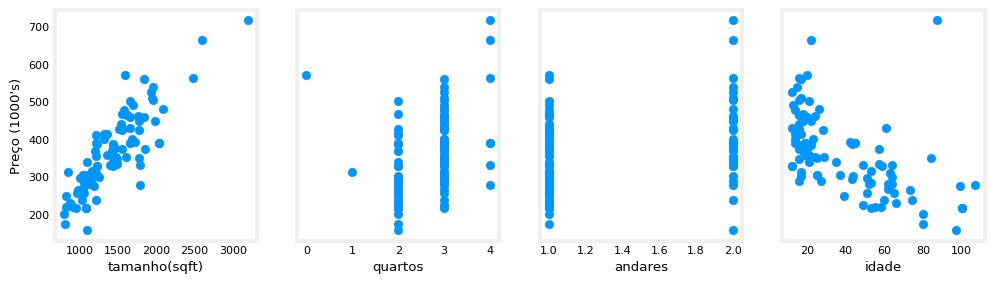

In [4]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Preço (1000's)")
plt.show()

A plotagem de cada recurso em relação à meta, o preço, fornece alguma indicação de quais recursos têm a maior influência sobre o preço. Acima, o aumento do tamanho também aumenta o preço. Quartos e pisos não parecem ter um forte impacto sobre o preço. As casas mais novas têm preços mais altos do que as casas mais antigas.

<a name="toc_15456_5"></a>
## Gradiente Descendente com Múltiplas Variáveis
Aqui estão as equações que você desenvolveu no último laboratório sobre descida de gradiente para várias variáveis:

$$\begin{align*} \text{repetir}&\text{ até a convergência:} \; \lbrace \newline\;
& w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j = 0..n-1}\newline
&b\ \ := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

onde n é o número de recursos, os parâmetros $w_j$, $b$ são atualizados simultaneamente e onde  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3}
\end{align}
$$
* m é o número de exemplos de treinamento no conjunto de dados

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ é a predição do modelo, enquanto $y^{(i)}$ é o valor alvo


## Taxa de Aprendizado
<figure>
    <img src="./images/C1_W2_Lab06_learningrate.PNG" style="width:1200px;" >
</figure>

As aulas discutiram alguns dos problemas relacionados à definição da taxa de aprendizado $\alpha$. A taxa de aprendizado controla o tamanho da atualização dos parâmetros. Veja a equação (1) acima. Ela é compartilhada por todos os parâmetros.  

Vamos executar a descida de gradiente e tentar algumas configurações de $\alpha$ em nosso conjunto de dados

### $\alpha$ = 9.9e-7

In [5]:
# definir alpha igual a 9.9e-7
_, _, hist = run_gradient_descent(X_train, y_train, 10, alpha = 9.9e-7)

Iteração custo          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 9.55884e+04  5.5e-01  1.0e-03  5.1e-04  1.2e-02  3.6e-04 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 1.28213e+05 -8.8e-02 -1.7e-04 -1.0e-04 -3.4e-03 -4.8e-05  6.4e+05  1.2e+03  6.2e+02  1.6e+04  4.1e+02
        2 1.72159e+05  6.5e-01  1.2e-03  5.9e-04  1.3e-02  4.3e-04 -7.4e+05 -1.4e+03 -7.0e+02 -1.7e+04 -4.9e+02
        3 2.31358e+05 -2.1e-01 -4.0e-04 -2.3e-04 -7.5e-03 -1.2e-04  8.6e+05  1.6e+03  8.3e+02  2.1e+04  5.6e+02
        4 3.11100e+05  7.9e-01  1.4e-03  7.1e-04  1.5e-02  5.3e-04 -1.0e+06 -1.8e+03 -9.5e+02 -2.3e+04 -6.6e+02
        5 4.18517e+05 -3.7e-01 -7.1e-04 -4.0e-04 -1.3e-02 -2.1e-04  1.2e+06  2.1e+03  1.1e+03  2.8e+04  7.5e+02
        6 5.63212e+05  9.7e-01  1.7e-03  8.7e-04  1.8e-02  6.6e-04 -1.3e+06 -2.5e+03 -1.3e+03 -3.1e+04 -

Parece que a taxa de aprendizado é muito alta.  A solução não converge. O custo está *crescendo* em vez de diminuir. Vamos plotar o resultado:

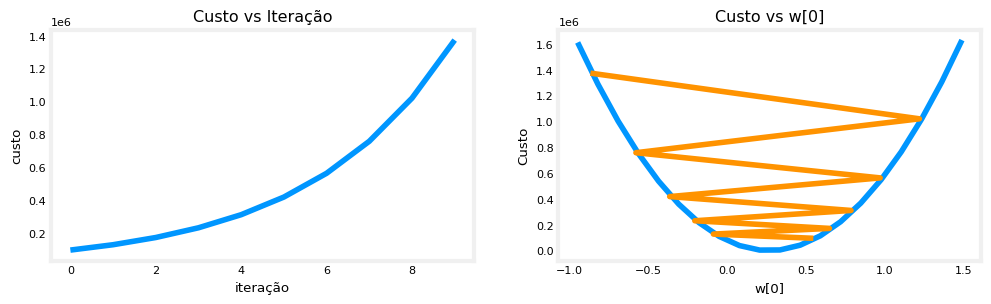

In [6]:
plot_cost_i_w(X_train, y_train, hist)

O gráfico à direita mostra o valor de um dos parâmetros, $w_0$. A cada iteração, ele está ultrapassando o valor ideal e, como resultado, o custo acaba *aumentando* em vez de se aproximar do mínimo. Observe que essa não é uma imagem totalmente precisa, pois há 4 parâmetros sendo modificados a cada passagem, em vez de apenas um. Esse gráfico está mostrando apenas $w_0$ com os outros parâmetros fixados em valores benignos. Neste gráfico e em gráficos posteriores, você pode notar que as linhas azul e laranja estão ligeiramente fora do padrão.


### $\alpha$ = 9e-7
Vamos tentar um valor um pouco menor e ver o que acontece.

In [7]:
# definir alpha igual a 9e-7
_,_,hist = run_gradient_descent(X_train, y_train, 10, alpha = 9e-7)

Iteração custo          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 6.64616e+04  5.0e-01  9.1e-04  4.7e-04  1.1e-02  3.3e-04 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 6.18990e+04  1.8e-02  2.1e-05  2.0e-06 -7.9e-04  1.9e-05  5.3e+05  9.8e+02  5.2e+02  1.3e+04  3.4e+02
        2 5.76572e+04  4.8e-01  8.6e-04  4.4e-04  9.5e-03  3.2e-04 -5.1e+05 -9.3e+02 -4.8e+02 -1.1e+04 -3.4e+02
        3 5.37137e+04  3.4e-02  3.9e-05  2.8e-06 -1.6e-03  3.8e-05  4.9e+05  9.1e+02  4.8e+02  1.2e+04  3.2e+02
        4 5.00474e+04  4.6e-01  8.2e-04  4.1e-04  8.0e-03  3.2e-04 -4.8e+05 -8.7e+02 -4.5e+02 -1.1e+04 -3.1e+02
        5 4.66388e+04  5.0e-02  5.6e-05  2.5e-06 -2.4e-03  5.6e-05  4.6e+05  8.5e+02  4.5e+02  1.2e+04  2.9e+02
        6 4.34700e+04  4.5e-01  7.8e-04  3.8e-04  6.4e-03  3.2e-04 -4.4e+05 -8.1e+02 -4.2e+02 -9.8e+03 -

O custo está diminuindo ao longo da execução, mostrando que o alfa não é muito grande. 

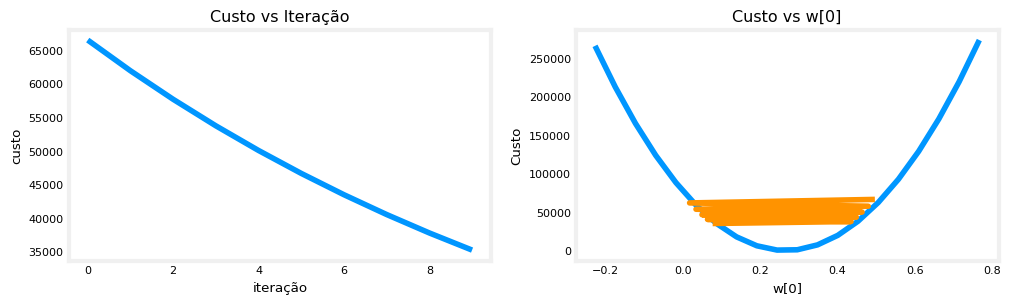

In [8]:
plot_cost_i_w(X_train, y_train, hist)

À esquerda, você vê que o custo está diminuindo como deveria. À direita, você pode ver que $w_0$ ainda está oscilando em torno do mínimo, mas o custo está diminuindo a cada iteração em vez de aumentar. Observe acima que `dj_dw[0]` muda de sinal a cada iteração, pois `w[0]` salta sobre o valor ideal.
Esse valor alfa convergirá. Você pode variar o número de iterações para ver como ele se comporta.

### $\alpha$ = 1e-7
Vamos tentar um valor um pouco menor para $\alpha$ e ver o que acontece.

In [9]:
# definir alpha igual a 1e-7
_,_,hist = run_gradient_descent(X_train, y_train, 10, alpha = 1e-7)

Iteração custo          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 4.42313e+04  5.5e-02  1.0e-04  5.2e-05  1.2e-03  3.6e-05 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 2.76461e+04  9.8e-02  1.8e-04  9.2e-05  2.2e-03  6.5e-05 -4.3e+05 -7.9e+02 -4.0e+02 -9.5e+03 -2.8e+02
        2 1.75102e+04  1.3e-01  2.4e-04  1.2e-04  2.9e-03  8.7e-05 -3.4e+05 -6.1e+02 -3.1e+02 -7.3e+03 -2.2e+02
        3 1.13157e+04  1.6e-01  2.9e-04  1.5e-04  3.5e-03  1.0e-04 -2.6e+05 -4.8e+02 -2.4e+02 -5.6e+03 -1.8e+02
        4 7.53002e+03  1.8e-01  3.3e-04  1.7e-04  3.9e-03  1.2e-04 -2.1e+05 -3.7e+02 -1.9e+02 -4.2e+03 -1.4e+02
        5 5.21639e+03  2.0e-01  3.5e-04  1.8e-04  4.2e-03  1.3e-04 -1.6e+05 -2.9e+02 -1.5e+02 -3.1e+03 -1.1e+02
        6 3.80242e+03  2.1e-01  3.8e-04  1.9e-04  4.5e-03  1.4e-04 -1.3e+05 -2.2e+02 -1.1e+02 -2.3e+03 -

O custo está diminuindo ao longo da execução, mostrando que $\alpha$ não é muito grande. 

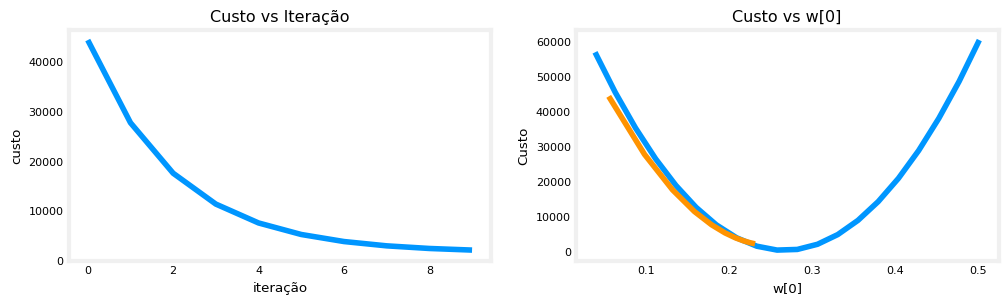

In [10]:
plot_cost_i_w(X_train,y_train,hist)

À esquerda, você vê que o custo está diminuindo como deveria. À direita, você pode ver que $w_0$ está se aproximando do mínimo sem oscilações. O `dj_w0` é negativo durante toda a execução. Essa solução também convergirá.

## _Feature Scaling_
<figure>
    <img src="./images/C1_W2_Lab06_featurescalingheader.PNG" style="width:1200px;" >
</figure>
As aulas descreveram a importância de redimensionar o conjunto de dados para que os recursos tenham um intervalo semelhante.
Se você estiver interessado em saber por que isso acontece, clique no link "Detalhes" abaixo. Caso contrário, a seção abaixo apresentará uma implementação de como fazer o _feature scaling_.

<details>
<summary>
    <font size='3', color='darkgreen'><b>Detalhes</b></font>
</summary>

Vejamos novamente a situação com $\alpha$ = 9e-7. Isso está bem próximo do valor máximo que podemos definir para $\alpha$ sem divergir. Esta é uma execução curta que mostra as primeiras iterações:

<figure>
    <img src="./images/C1_W2_Lab06_ShortRun.PNG" style="width:1200px;" >
</figure>

Acima, enquanto o custo está sendo reduzido, fica claro que $w_0$ está progredindo mais rapidamente do que os outros parâmetros devido ao seu gradiente muito maior.

O gráfico abaixo mostra o resultado de uma execução muito longa com $\alpha$ = 9e-7. Isso leva vaaaaárias horas :-)

<figure>
    <img src="./images/C1_W2_Lab06_LongRun.PNG" style="width:1200px;" >
</figure>
    
Acima, você pode ver que o custo diminuiu lentamente após a redução inicial. Observe a diferença entre `w0` e `w1`, `w2`, `w3`, bem como `dj_dw0` e `dj_dw1-3`. O `w0` atinge seu valor quase final muito rapidamente e o `dj_dw0` diminuiu rapidamente para um valor pequeno, mostrando que o `w0` está próximo do valor final. Os outros parâmetros foram reduzidos muito mais lentamente.

Por que isso acontece?  Há algo que podemos melhorar? Veja abaixo:
<figure>
    <center> <img src="./images/C1_W2_Lab06_scale.PNG"   ></center>
</figure>   

A figura acima mostra por que os $w$ são atualizados de forma desigual. 
- $\alpha$ é compartilhado por todas as atualizações de parâmetros ($w$'s e $b$).
- o termo de erro comum é multiplicado pelos recursos para os $w$'s. (não $b$).
- os recursos variam significativamente em magnitude, fazendo com que alguns recursos sejam atualizados muito mais rapidamente do que outros. Nesse caso, $w_0$ é multiplicado por 'size(sqft)', que geralmente é > 1000, enquanto $w_1$ é multiplicado por 'number of bedrooms', que geralmente é 2-4. 
    
A solução é o _feature scaling_.

As aulas discutiram três técnicas diferentes: 
- _Feature scaling_, essencialmente dividindo cada recurso positivo por seu valor máximo ou, de forma mais geral, redimensionando cada recurso por seus valores mínimo e máximo usando (x-min)/(max-min). Ambas as formas normalizam os recursos para o intervalo de -1 e 1, sendo que o primeiro método funciona para recursos positivos, o que é simples e serve bem para o exemplo da aula, e o segundo método funciona para quaisquer recursos.
- Normalização média: $x_i := \dfrac{x_i - \mu_i}{max - min} $ 
- Normalização com _z-score_ que exploraremos a seguir. 


### Normalização z-score
Após a normalização _z_score_, todos os recursos terão uma média de 0 e um desvio padrão de 1.

Para implementar a normalização do escore z, ajuste os valores de entrada conforme mostrado nesta fórmula:

$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{4}$$ 
em que $j$ seleciona um recurso ou uma coluna na matriz $\mathbf{X}$. $µ_j$ é a média de todos os valores do recurso (j) e $\sigma_j$ é o desvio padrão do recurso (j).
$$
\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j \tag{5}\\
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2  \tag{6}
\end{align}
$$

>**Nota de implementação:** Quando normalizar os recursos é importante
armazenar os valores usados para normalização - o valor médio e o desvio padrão usados para os cálculos. Depois de aprender os parâmetros
do modelo, geralmente queremos prever os preços de casas que não vimos antes. Dado um novo valor x (área da sala de estar e número de quartos), devemos primeiro normalizar o valor médio e o desvio padrão que havíamos calculado anteriormente com base no conjunto de treinamento.

**Implementação**

In [11]:
def zscore_normalize_features(X):
    """
    calcula  X, zcore normalizado por coluna
    
    Args:
      X (ndarray (m,n))     : dados de entrada, m exemplos, n recursos
      
    Returns:
      X_norm (ndarray (m,n)): entrada normalizada por coluna
      mu (ndarray (n,))     : média de cada recurso
      sigma (ndarray (n,))  : desvio padrão de cada recurso
    """
    # Encontre a média de cada coluna/recurso
    mu     = np.mean(X, axis=0)   # mu terá a forma (n,)
    # Encontre o desvio padrão de cada coluna/recurso
    sigma  = np.std(X, axis=0)  # sigma terá a forma (n,)
    # subtraia mu elemento-a-elemento dessa coluna para cada exemplo, divida por sigma para cada coluna
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)
 
#verifique nosso trabalho
#from sklearn.preprocessing import scale
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)

Vejamos as etapas envolvidas na normalização do escore Z. O gráfico abaixo mostra a transformação passo a passo.

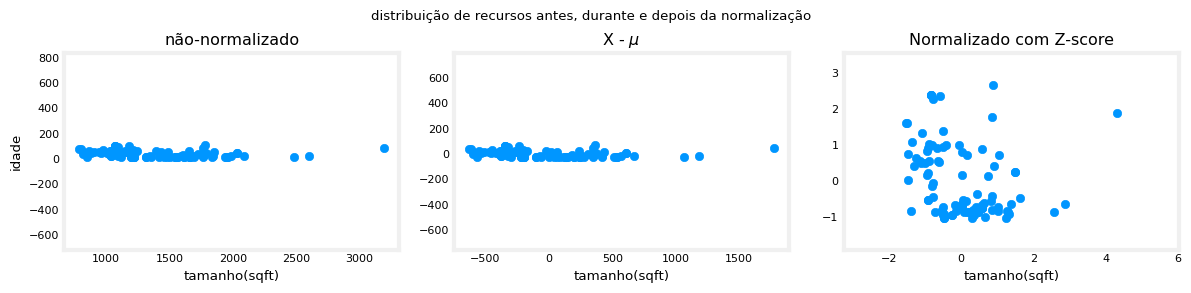

In [12]:
mu     = np.mean(X_train,axis=0)   
sigma  = np.std(X_train,axis=0) 
X_mean = (X_train - mu)
X_norm = (X_train - mu)/sigma      

fig,ax=plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(X_train[:,0], X_train[:,3])
ax[0].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[0].set_title("não-normalizado")
ax[0].axis('equal')

ax[1].scatter(X_mean[:,0], X_mean[:,3])
ax[1].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[1].set_title(r"X - $\mu$")
ax[1].axis('equal')

ax[2].scatter(X_norm[:,0], X_norm[:,3])
ax[2].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[2].set_title(r"Normalizado com Z-score")
ax[2].axis('equal')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("distribuição de recursos antes, durante e depois da normalização")
plt.show()

O gráfico acima mostra a relação entre dois dos parâmetros do conjunto de treinamento, "idade" e "tamanho (sqft)". *Esses são plotados em escala igual. 
- Esquerda: não normalizado: O intervalo de valores ou a variação do recurso "size(sqft)" é muito maior do que o da idade
- Meio: A primeira etapa remove a média ou o valor médio de cada recurso. Isso deixa os recursos centrados em zero. É difícil ver a diferença para o recurso "idade", mas "size(sqft)" está claramente em torno de zero.
- Certo: A segunda etapa divide pelo desvio padrão. Isso deixa os dois recursos centralizados em zero com uma escala semelhante.

Vamos normalizar os dados e compará-los com os dados originais.

In [13]:
# normalizar os recursos originais
X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Faixa de pico a pico por coluna com dados originais        X:{np.ptp(X_train,axis=0)}")   
print(f"Faixa de pico a pico por coluna em X normalizado:{np.ptp(X_norm,axis=0)}")

X_mu = [1.42e+03 2.72e+00 1.38e+00 3.84e+01], 
X_sigma = [411.62   0.65   0.49  25.78]
Faixa de pico a pico por coluna com dados originais        X:[2.41e+03 4.00e+00 1.00e+00 9.50e+01]
Faixa de pico a pico por coluna em X normalizado:[5.85 6.14 2.06 3.69]


O intervalo de pico a pico de cada coluna é reduzido de um fator de milhares para um fator de 2 a 3 por meio da normalização.

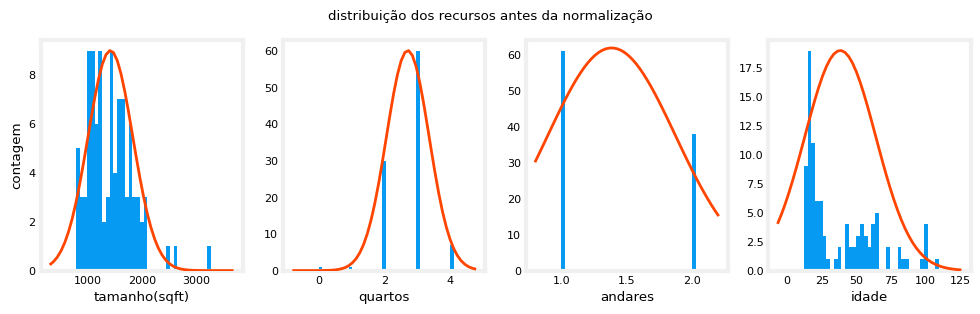

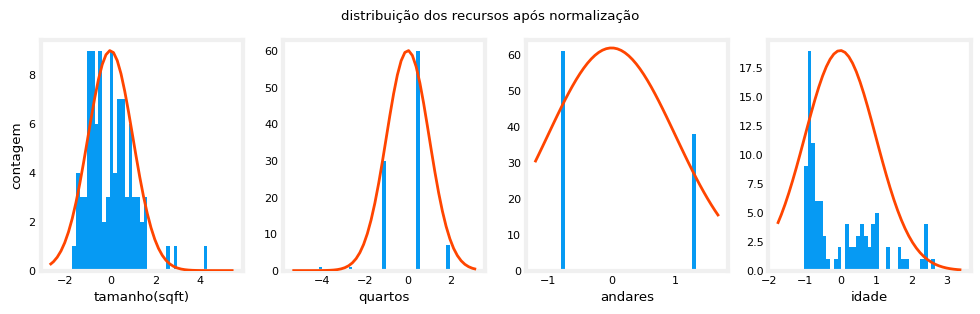

In [14]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3))
for i in range(len(ax)):
    norm_plot(ax[i],X_train[:,i],)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("contagem");
fig.suptitle("distribuição dos recursos antes da normalização")
plt.show()
fig,ax=plt.subplots(1,4,figsize=(12,3))
for i in range(len(ax)):
    norm_plot(ax[i],X_norm[:,i],)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("contagem"); 
fig.suptitle("distribuição dos recursos após normalização")

plt.show()

Observe, acima, que o intervalo dos dados normalizados (eixo x) está centrado em zero e aproximadamente +/- 2. O mais importante é que o intervalo é semelhante para cada recurso.

Vamos executar novamente nosso algoritmo de descida de gradiente com dados normalizados.
Observe o valor **muito maior de alfa**. Isso acelerará a descida do gradiente.

In [15]:
w_norm, b_norm, hist = run_gradient_descent(X_norm, y_train, 1000, 1.0e-1, )

Iteração custo          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 5.76170e+04  8.9e+00  3.0e+00  3.3e+00 -6.0e+00  3.6e+01 -8.9e+01 -3.0e+01 -3.3e+01  6.0e+01 -3.6e+02
      100 2.21086e+02  1.1e+02 -2.0e+01 -3.1e+01 -3.8e+01  3.6e+02 -9.2e-01  4.5e-01  5.3e-01 -1.7e-01 -9.6e-03
      200 2.19209e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -3.0e-02  1.5e-02  1.7e-02 -6.0e-03 -2.6e-07
      300 2.19207e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -1.0e-03  5.1e-04  5.7e-04 -2.0e-04 -6.9e-12
      400 2.19207e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -3.4e-05  1.7e-05  1.9e-05 -6.6e-06 -2.7e-13
      500 2.19207e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -1.1e-06  5.6e-07  6.2e-07 -2.2e-07 -2.6e-13
      600 2.19207e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -3.7e-08  1.9e-08  2.1e-08 -7.3e-09 -

Os _feature scaling_ obtêm resultados muito precisos **muito, muito mais rápido!** :-). Observe que o gradiente de cada parâmetro é pequeno ao final dessa execução relativamente curta. Uma taxa de aprendizado de 0,1 é um bom começo para a regressão com recursos normalizados.
Vamos plotar nossas previsões em relação aos valores-alvo. Observe que a previsão é feita usando o recurso normalizado, enquanto o gráfico é mostrado usando os valores originais do recurso.

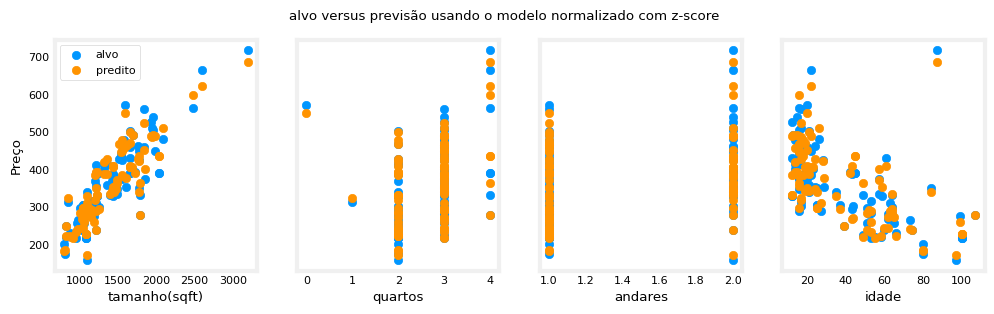

In [16]:
#Prever o alvo usando recursos normalizados
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_norm) + b_norm

    # Traçar previsões e alvos em relação aos recursos originais    
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'alvo')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:,i],yp,color=dlc["dlorange"], label = 'predito')
ax[0].set_ylabel("Preço"); ax[0].legend();
fig.suptitle("alvo versus previsão usando o modelo normalizado com z-score")
plt.show()

Os resultados parecem bons. Alguns pontos a serem observados:
- com vários recursos, não podemos mais ter um único gráfico mostrando resultados versus recursos.
- Ao gerar o gráfico, foram usados os recursos normalizados. Todas as previsões que usam os parâmetros aprendidos em um conjunto de treinamento normalizado também devem ser normalizadas.

**Previsão**
O objetivo de gerar nosso modelo é usá-lo para prever preços de imóveis que não estão no conjunto de dados. Vamos prever o preço de uma casa com 1.200 pés quadrados, 3 quartos, 1 andar, 40 anos de idade. Lembre-se de que você deve normalizar os dados com a média e o desvio padrão calculados quando os dados de treinamento foram normalizados. 

In [17]:
# Primeiro, normalizar nosso exemplo.
x_house = np.array([1200, 3, 1, 40])
x_house_norm = (x_house - X_mu) / X_sigma
print(x_house_norm)
x_house_predict = np.dot(x_house_norm, w_norm) + b_norm
print(f" Preço previsto de uma casa com 1200 pés quadrados, 3 quartos, 1 andar, 40 anos de idade = ${x_house_predict*1000:0.0f}")

[-0.53  0.43 -0.79  0.06]
 Preço previsto de uma casa com 1200 pés quadrados, 3 quartos, 1 andar, 40 anos de idade = $318709


**Contornos(curvas de nível) de Custo**  
<img align="left" src="./images/C1_W2_Lab06_contours.PNG"   style="width:240px;" >Outra maneira de visualizar o _feature scaling_ é em termos de contornos de custo. Quando as escalas dos recursos não coincidem, o gráfico de custo versus parâmetros em um gráfico de contorno é assimétrico. 

No gráfico abaixo, a escala dos parâmetros é a combinada. O gráfico à esquerda é o gráfico de contorno de custo de w[0], os pés quadrados versus w[1], o número de quartos antes de normalizar os recursos. O gráfico é tão assimétrico que as curvas que completam os contornos não são visíveis. Em contrapartida, quando os recursos são normalizados, o contorno do custo é muito mais simétrico. O resultado é que as atualizações dos parâmetros durante a descida do gradiente podem fazer o mesmo progresso para cada parâmetro. 

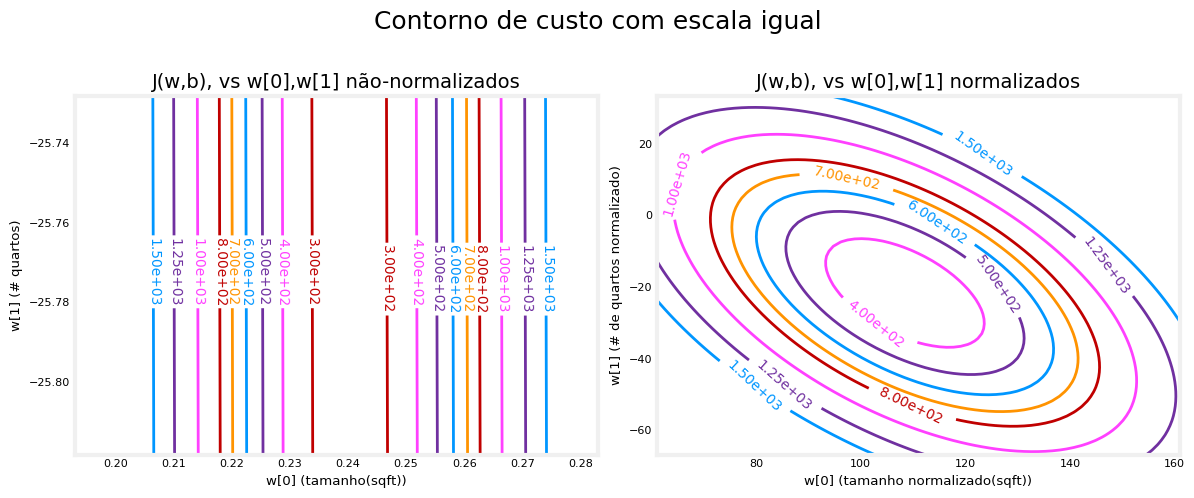

In [18]:
plt_equal_scale(X_train, X_norm, y_train)


## Parabéns!
Neste laboratório, você:
- utilizou as rotinas de regressão linear com vários recursos que desenvolveu nos laboratórios anteriores
- explorou o impacto da taxa de aprendizado $\alpha$ na convergência 
- descobriu o valor do escalonamento de recursos usando a normalização do escore z para acelerar a convergência